# [문자-단위 RNN으로 이름 분류](https://tutorials.pytorch.kr/intermediate/char_rnn_classification_tutorial.html)

18개 언어로 된 수천 개의 성을 훈련시키고, 철자에 따라 이름이 어떤 언어인지 예측합니다.  

```
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish
```

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

# 1.데이터 준비
> [데이터 다운로드](https://download.pytorch.org/tutorial/data.zip)

데이터는 [Language].txt 라는 18개의 텍스트 파일로 구성되어 있습니다. 각 파일에는 한 줄에 하나의 이름이 포함되어 있으며, 대부분 로마자로 되어 있습니다.

## unicodedata

파이썬으로 텍스트 전처리를 하다가 정규식으로 한글 영어만 추출할 때, 가끔 데이터가 None이 되는 경우가 많이 발생한다.   
그런 경우에는 대부분 같은 문자이지만 `아스키 코드가 달라서` 발생하는 문제들이다.   

이런 이슈(오류)들을 피하기 위해서 유니코드 정규화를 해야 한다.

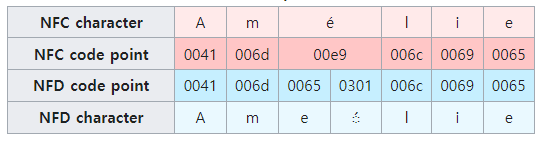

In [ ]:
import unicodedata

- NFC(Normal From Composed):   
구성된 문자 반환

In [ ]:
unicodedata.normalize('NFC', 'Hello')

'Hello'

- NFD(Normal Form Decomposed):   
분해, 결합된 문자 제공

In [ ]:
unicodedata.normalize('NFD', 'Hello')

'Hello'

`unicodedata.category(chr)`:   
> chr 문자에 할당된 일반 범주(general category)를 문자열로 반환합니다.
> - `Mn`: Mark, no spacing(발음구별기호)
> - `LI`: Letter, lower case 
> - `Lu`: Letter, upper case


In [ ]:
unicodedata.category('c')

'Ll'

In [ ]:
unicodedata.category('C')

'Lu'

## 유니코드 문자열을 ASCII로 변환 

In [ ]:
string.ascii_letters

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [ ]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'  # Mn은 Mark, no spacing 를 뜻함.
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [ ]:
print(f'all_letters: {all_letters}')
print(f'n_letters: {n_letters}')

all_letters: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
n_letters: 57


## 데이터 로드 

In [ ]:
# 구글 드라이브 연결(데이터 로드를 위해서)
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [ ]:
DATA_PATH = "/content/data/MyDrive/google_lecture/06. deep learning/3. NLP Pytorch/data/"

In [ ]:
for filename in glob.glob(DATA_PATH+'names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    print(f'category: {category}')

category: German
category: Spanish
category: Greek
category: Chinese
category: Portuguese
category: Scottish
category: Korean
category: Vietnamese
category: English
category: Russian
category: French
category: Polish
category: Arabic
category: Irish
category: Dutch
category: Japanese
category: Czech
category: Italian


In [ ]:
# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [ ]:
print(f'filename: {filename}')
lines = readLines(filename)
print(f'lines: {lines}')

filename: /content/data/MyDrive/google_lecture/06. deep learning/3. NLP Pytorch/data/names/Italian.txt
lines: ['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni', 'Abatescianni', 'Abba', 'Abbadelli', 'Abbascia', 'Abbatangelo', 'Abbatantuono', 'Abbate', 'Abbatelli', 'Abbaticchio', 'Abbiati', 'Abbracciabene', 'Abbracciabeni', 'Abelli', 'Abello', 'Abrami', 'Abramo', 'Acardi', 'Accardi', 'Accardo', 'Acciai', 'Acciaio', 'Acciaioli', 'Acconci', 'Acconcio', 'Accorsi', 'Accorso', 'Accosi', 'Accursio', 'Acerbi', 'Acone', 'Aconi', 'Acqua', 'Acquafredda', 'Acquarone', 'Acquati', 'Adalardi', 'Adami', 'Adamo', 'Adamoli', 'Addario', 'Adelardi', 'Adessi', 'Adimari', 'Adriatico', 'Affini', 'Africani', 'Africano', 'Agani', 'Aggi', 'Aggio', 'Agli', 'Agnelli', 'Agnellutti', 'Agnusdei', 'Agosti', 'Agostini', 'Agresta', 'Agrioli', 'Aiello', 'Aiolfi', 'Airaldi', 'Airo', 'Aita', 'Ajello', 'Alagona', 'Alamanni', 'Albanesi', 'Albani', 'Albano', 'Alberghi', 'Alberghini', 'Alberici', 'Alberighi'

In [ ]:
# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

for filename in glob.glob(DATA_PATH+'names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0] # 파일명(나라이름) 
    all_categories.append(category) 
    lines = readLines(filename) # 파일의 데이터(나라별 이름들)
    category_lines[category] = lines

n_categories = len(all_categories)

print(category_lines['Korean'][:5])

['Ahn', 'Baik', 'Bang', 'Byon', 'Cha']


In [ ]:
category_lines.keys()

dict_keys(['German', 'Spanish', 'Greek', 'Chinese', 'Portuguese', 'Scottish', 'Korean', 'Vietnamese', 'English', 'Russian', 'French', 'Polish', 'Arabic', 'Irish', 'Dutch', 'Japanese', 'Czech', 'Italian'])

In [ ]:
all_categories

['German',
 'Spanish',
 'Greek',
 'Chinese',
 'Portuguese',
 'Scottish',
 'Korean',
 'Vietnamese',
 'English',
 'Russian',
 'French',
 'Polish',
 'Arabic',
 'Irish',
 'Dutch',
 'Japanese',
 'Czech',
 'Italian']

## 이름을 Tensor로 변경
> One-Hot vector를 사용하여 Tensor로 변경

In [ ]:
'''
.. NOTE::
역자 주:  One-Hot 벡터는 언어를 다룰 때 자주 이용되며,
단어, 글자 등을 벡터로 표현할 때 단어, 글자 사이의 상관 관계를 미리 알 수 없을 경우,
One-Hot으로 표현하여 서로 직교한다고 가정하고 학습을 시작합니다.
이와 동일하게, 상관 관계를 알 수 없는 다른 데이터의 경우에도 One-Hot 벡터를 활용할 수 있습니다.
'''

import torch

# all_letters 로 문자의 주소 찾기, 예시 "a" = 0, b = 1
def letterToIndex(letter):
    return all_letters.find(letter)

# 검증을 위해서 한 개의 문자를 <1 x n_letters> Tensor로 변환
def letterToTensor(letter): # 문자별 원-핫 인코딩 
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 한 줄(이름)을  <line_length x 1 x n_letters>,
# 또는 One-Hot 문자 벡터의 Array로 변경
def lineToTensor(line): # 글자별 원-핫 인코딩 
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(all_letters)
print('-'*50)
print(letterToTensor('e'))
print('-'*50)
print(lineToTensor('Jones').shape) # print(lineToTensor('Jones').size())

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
--------------------------------------------------
tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
--------------------------------------------------
torch.Size([5, 1, 57])


# 2.RNN 클래스 생성 

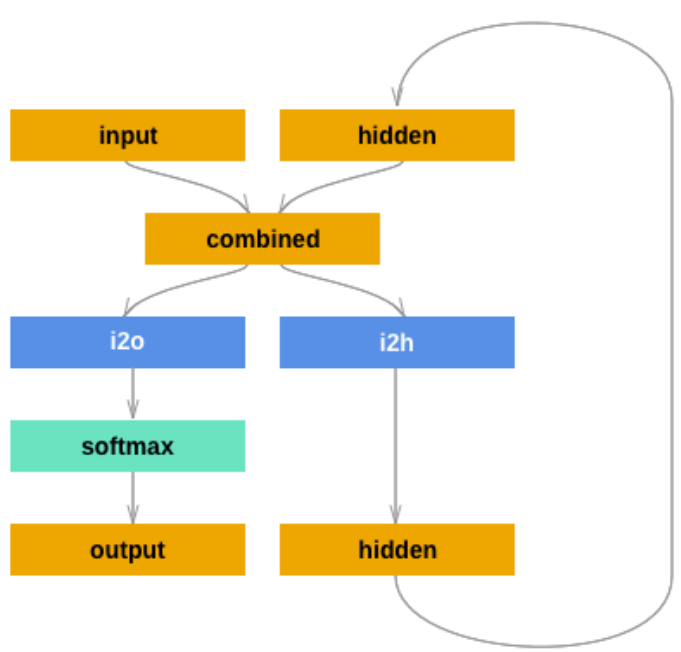

위의 RNN 구조를 구현한 클레스입니다.

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self): # hidden state 초기값 세팅 
        return torch.zeros(1, self.hidden_size)

In [ ]:
print(f'n_letters: {n_letters} / n_categories: {n_categories}')

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
rnn

n_letters: 57 / n_categories: 18


RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torchinfo

In [ ]:
# input.shape: [batch size, letters size] -> (32, 57)
# hidden.shape: [batch size, hidden size] -> (32, 128)
# (sinput, hidden) -> ((32, 57), (32, 128))
torchinfo.summary(rnn, ((32, 57), (32, 128))) 

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [32, 18]                  --
├─Linear: 1-1                            [32, 128]                 23,808
├─Linear: 1-2                            [32, 18]                  3,348
├─LogSoftmax: 1-3                        [32, 18]                  --
Total params: 27,156
Trainable params: 27,156
Non-trainable params: 0
Total mult-adds (M): 0.87
Input size (MB): 0.02
Forward/backward pass size (MB): 0.04
Params size (MB): 0.11
Estimated Total Size (MB): 0.17

이 네트워크의 한 단계를 실행하려면 입력(현재 문자 Tensor)과 이전의 은닉 상태(처음에는 0으로 초기화)를 전달해야 합니다.    
출력(각 언어의 확률)과 다음 은닉 상태(다음 단계를 위해 유지)를 돌려받습니다.

In [ ]:
input = letterToTensor('A') # 입력
hidden = rnn.initHidden() # 처음에는 0으로 초기화

output, next_hidden = rnn(input, hidden)

In [ ]:
print(f'{next_hidden.shape}')
next_hidden

torch.Size([1, 128])


tensor([[ 2.7480e-02,  9.4205e-03, -6.2804e-02, -8.2778e-02, -7.7893e-02,
          1.7318e-03,  2.6577e-02,  9.7340e-02, -2.9673e-02,  1.7252e-02,
         -9.1442e-03,  2.6706e-02, -3.6588e-02,  7.0490e-02,  1.0156e-01,
         -3.1430e-02, -1.2964e-01, -6.1999e-02,  9.5434e-02,  3.9354e-02,
         -2.2501e-02,  7.0806e-02,  5.6257e-02,  1.9096e-02, -1.1685e-01,
         -8.5360e-02, -6.3074e-02,  1.2342e-02, -6.5857e-02,  1.2770e-02,
         -7.6495e-02,  4.1746e-03,  1.6089e-02, -2.5761e-02,  4.0586e-02,
          7.6156e-02, -4.4697e-02,  3.7352e-02,  3.7871e-04,  3.1699e-02,
         -7.6022e-02,  1.5284e-02,  1.4360e-02,  8.6778e-02,  1.1396e-03,
         -2.6663e-03,  2.1596e-03, -1.1418e-01,  1.3112e-02,  1.0893e-01,
         -3.3187e-02, -7.6372e-03, -1.7850e-02, -7.8159e-02, -4.3090e-02,
          7.1723e-02, -1.0945e-01, -3.7801e-02, -8.8284e-02,  2.9444e-02,
          6.3638e-02,  6.9700e-02, -5.5566e-02,  3.6494e-02, -1.3901e-01,
          5.7330e-02, -9.8888e-02, -6.

In [ ]:
print(f'{output.shape}')
output

torch.Size([1, 18])


tensor([[-2.8906, -2.7614, -2.8194, -2.9234, -2.8444, -2.8179, -2.8836, -2.8723,
         -2.9756, -2.9425, -2.8998, -2.9123, -2.9322, -2.8780, -2.8899, -2.9949,
         -2.8368, -2.9845]], grad_fn=<LogSoftmaxBackward0>)

In [ ]:
top_n, top_i = output.topk(1) # topk(n) 텐서의 가장 큰 n번째 값 및 주소

top_n, top_i

(tensor([[-2.7614]], grad_fn=<TopkBackward0>), tensor([[1]]))

In [ ]:
category_i = top_i[0].item()   # 텐서에서 정수 값으로 변경

category_i, all_categories[category_i]

(1, 'Spanish')

# 3.학습

## 학습 준비
학습결과인 `output`을 해석할 수 있는 함수 생성

In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)  # topk(n) 텐서의 가장 큰 n번째 값 및 주소
    category_i = top_i[0].item()   # 텐서에서 정수 값으로 변경
    return all_categories[category_i], category_i

In [ ]:
print(categoryFromOutput(output))

('Spanish', 1)


In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories) # 나라를 랜덤으로 선택 
    line = randomChoice(category_lines[category]) # 이름을 랜덤으로 선택 
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(5):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print(f'category = {category} / line = {line}')
    print(f'category_tensor = {category_tensor.shape} / line_tensor = {line_tensor.shape}')
    print('-'*70)

category = Spanish / line = Del bosque
category_tensor = torch.Size([1]) / line_tensor = torch.Size([10, 1, 57])
----------------------------------------------------------------------
category = Russian / line = Bass
category_tensor = torch.Size([1]) / line_tensor = torch.Size([4, 1, 57])
----------------------------------------------------------------------
category = Vietnamese / line = Vinh
category_tensor = torch.Size([1]) / line_tensor = torch.Size([4, 1, 57])
----------------------------------------------------------------------
category = Korean / line = Jeong
category_tensor = torch.Size([1]) / line_tensor = torch.Size([5, 1, 57])
----------------------------------------------------------------------
category = Japanese / line = Fujiwara
category_tensor = torch.Size([1]) / line_tensor = torch.Size([8, 1, 57])
----------------------------------------------------------------------


## 네트워크 학습

학습 루프
1. 입력과 목표 Tensor 생성
2. 0으로 초기화 된 은닉 상태 생성
3. 각 문자 읽기
4. 다음 준자를 위한 은닉 상태 유지
5. 목표와 최종 출력 비교 
6. 역전파
7. 출력과 손실 반환 

In [ ]:
criterion = nn.NLLLoss() # 손실함수

In [ ]:
learning_rate = 0.005  # 학습률을 너무 높게 설정하면 발산할 수 있고, 너무 낮으면 학습이 되지 않을 수 있습니다.

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden() # hidden 초기화 

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # 매개변수의 경사도에 학습률을 곱해서 그 매개변수의 값에 더합니다.
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample() # 랜덤으로 학습 데이터 추출
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # iter 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.2312 Onishi / Japanese ✓
10000 10% (0m 17s) 2.9376 Korycan / Irish ✗ (Czech)
15000 15% (0m 27s) 1.3362 Coghlan / Irish ✓
20000 20% (0m 33s) 2.2188 O'Brien / Dutch ✗ (Irish)
25000 25% (0m 39s) 0.9250 Leeuwenhoeck / Dutch ✓
30000 30% (0m 45s) 0.1846 Pirojkov / Russian ✓
35000 35% (0m 51s) 2.1451 Carson / Scottish ✗ (English)
40000 40% (0m 57s) 0.1437 Thach / Vietnamese ✓
45000 45% (1m 4s) 1.3645 Tse / Chinese ✓
50000 50% (1m 10s) 2.6379 De fiore / French ✗ (Italian)
55000 55% (1m 16s) 3.8851 Tighearnach / Russian ✗ (Irish)
60000 60% (1m 22s) 1.9753 Soukup / Russian ✗ (Czech)
65000 65% (1m 28s) 2.7609 Lamb / Arabic ✗ (English)
70000 70% (1m 35s) 0.0789 Kusuhara / Japanese ✓
75000 75% (1m 41s) 2.8844 Duncan / Irish ✗ (Scottish)
80000 80% (1m 48s) 2.5116 Ba / Vietnamese ✗ (Arabic)
85000 85% (1m 55s) 1.5800 Antoun / French ✗ (Arabic)
90000 90% (2m 2s) 3.4567 Langlais / Greek ✗ (French)
95000 95% (2m 8s) 1.9755 Rompaij / Russian ✗ (Dutch)
100000 100% (2m 14s) 2.2145 Ferreira

## 결과 확인

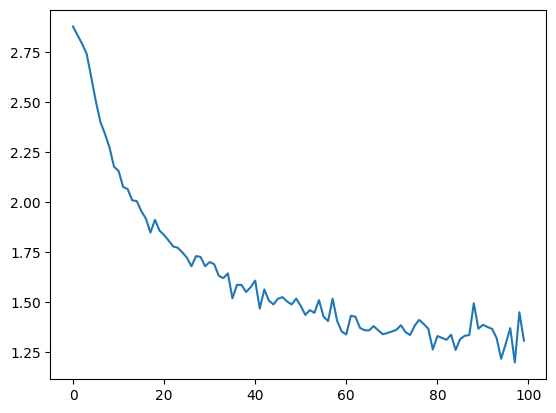

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# 4.결과 평가

네트워크(모델)가 다른 카테고리에서 얼마나 잘 작동하는지 보기 위해 모든 실제 언어(행)가 네트워크에서 어떤 언어로 추측(열)되는지 나타내는 `confusion matrix`를 만듭니다.   
`confusion matrix`를 계산하기 위해 `evaluate()`로 많으 수의 샘플을 네트워크에 실행합니다. (`evaluate()`는 `train()`에서 역전파를 빼면 동일합니다.)

In [ ]:
# 주어진 라인의 출력 반환
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

<ipython-input-37-d4ed9d43dc20>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-37-d4ed9d43dc20>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


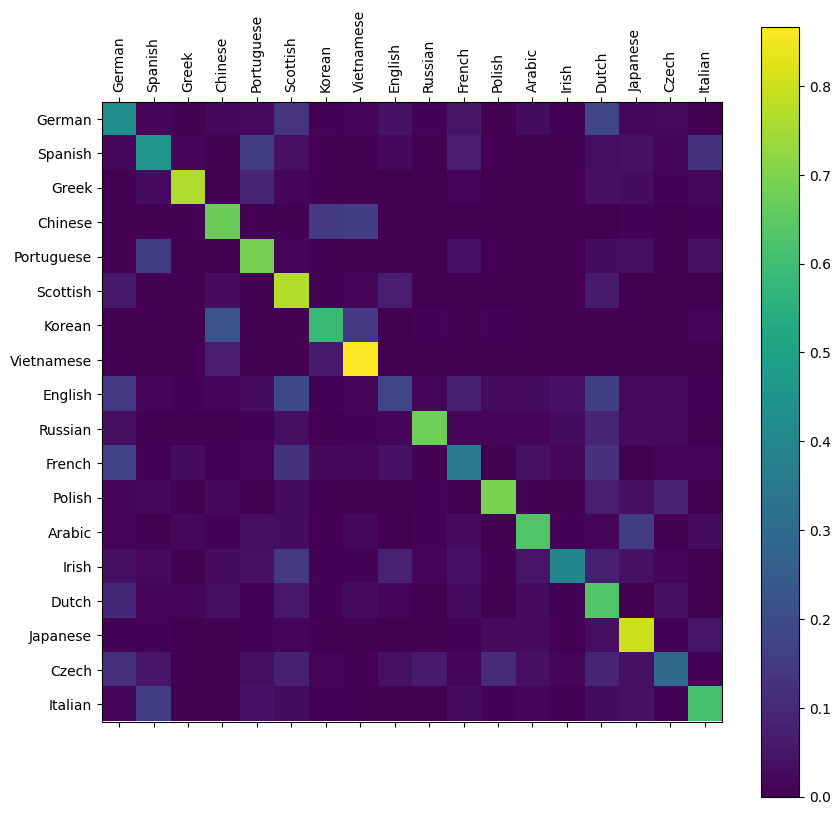

In [ ]:
# 혼란 행렬에서 정확한 추측을 추적
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 예시 중 어떤 것이 정확히 예측되었는지 기록
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 모든 행을 합계로 나누어 정규화
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 도식 설정
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 레이블 지정
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

## 사용자 입력

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [ ]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.86) Russian
(-1.00) Czech
(-2.18) English

> Jackson
(-0.15) Scottish
(-2.72) English
(-3.29) Dutch

> Satoshi
(-0.88) Italian
(-2.02) Japanese
(-2.20) Polish
